In [296]:
import os; os.environ['CUDA_VISIBLE_DEVICES'] = "1"

In [297]:
DATASET_PATH = '/home/bml/datasets/carvana-image-masking-challenge/'

In [298]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
from tensorflow import keras

In [299]:
tf.enable_v2_behavior()

# Dataset

In [300]:
ds_dir = Path(DATASET_PATH)

images_dir = ds_dir / 'train'
masks_dir = ds_dir / 'train_masks'

In [301]:
images_path = np.array(sorted(map(str, images_dir.iterdir())))
masks_path = np.array(sorted(map(str, masks_dir.iterdir())))

## Split

In [302]:
samples = len(images_path)
train_size = int(samples * 0.8)
val_size = samples - train_size

In [303]:
indexes = np.random.permutation(samples)

train_indexes = indexes[:train_size]
val_indexes = indexes[train_size:]

In [304]:
BATCH_SIZE=8
IMG_SIZE=(224, 224)

In [305]:
def read_image(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255
    
    return tf.cast(img, tf.float32)

def read_mask(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_gif(img)
    img = img[0]
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.image.rgb_to_grayscale(img)
    img = img > 0.1
    return tf.cast(img, tf.float32)

In [306]:
train_images = (tf.data.Dataset
                .from_tensor_slices(images_path[train_indexes])
                .map(read_image))
train_masks = (tf.data.Dataset
               .from_tensor_slices(masks_path[train_indexes])
               .map(read_mask))

train = (tf.data.Dataset.zip((train_images, train_masks)))

In [307]:
val_images = (tf.data.Dataset
                .from_tensor_slices(images_path[val_indexes])
                .map(read_image))
val_masks = (tf.data.Dataset
               .from_tensor_slices(masks_path[val_indexes])
               .map(read_mask))

val = (tf.data.Dataset.zip((val_images, val_masks)))

In [308]:
img, mask = next(iter(train))

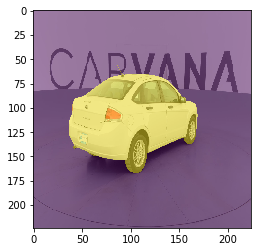

In [309]:
plt.imshow(img)
plt.imshow(mask[:, :, 0], alpha=0.5)

### Create loader

In [310]:
from tensorflow.data.experimental import AUTOTUNE

In [311]:
train_loader = (
    train
    .shuffle(100)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE))

val_loader = (
    val
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE))

In [312]:
(imgs, masks) = next(iter(val_loader))

In [313]:
imgs.shape, masks.shape

(TensorShape([8, 224, 224, 3]), TensorShape([8, 224, 224, 1]))

# Model

In [314]:
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Conv2D, MaxPool2D, UpSampling2D, Concatenate, Input)

In [315]:
def down(input_layer, filters, pool=True):
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(input_layer)
    residual = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    if pool:
        max_pool = MaxPool2D()(residual)
        return max_pool, residual
    else:
        return residual

def up(input_layer, residual, filters):
    filters=int(filters)
    upsample = UpSampling2D()(input_layer)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding="same")(upsample)
    concat = Concatenate(axis=3)([residual, upconv])
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(concat)
    conv2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    return conv2

In [316]:
def make_model():
    filters = 64
    input_layer = Input(shape=[224, 224, 3])
    layers = [input_layer]
    residuals = []
    
    # Down 1, 128
    d1, res1 = down(input_layer, filters)
    residuals.append(res1)

    filters *= 2

    # Down 2, 64
    d2, res2 = down(d1, filters)
    residuals.append(res2)

    filters *= 2

    # Down 3, 32
    d3, res3 = down(d2, filters)
    residuals.append(res3)

    filters *= 2

    # Down 4, 16
    d4, res4 = down(d3, filters)
    residuals.append(res4)

    filters *= 2

    # Down 5, 8
    d5 = down(d4, filters, pool=False)

    # Up 1, 16
    up1 = up(d5, residual=residuals[-1], filters=filters/2)

    filters /= 2

    # Up 2,  32
    up2 = up(up1, residual=residuals[-2], filters=filters/2)

    filters /= 2

    # Up 3, 64
    up3 = up(up2, residual=residuals[-3], filters=filters/2)

    filters /= 2

    # Up 4, 128
    up4 = up(up3, residual=residuals[-4], filters=filters/2)

    out = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(up4)

    model = Model(input_layer, out)
    
    return model

In [317]:
model = make_model()

# Loss Function and Metrics

In [318]:
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    
    y_true = tf.round(tf.reshape(y_true, [-1]))
    y_pred = tf.round(tf.reshape(y_pred, [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

# Train

In [319]:
from tensorflow.keras.optimizers import Adam

In [320]:
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=[dice_coef])

In [321]:
model.fit(train_loader, epochs=5)

Epoch 1/5
509/509 [==============================] - 157s 309ms/step - loss: 0.0980 - dice_coef: 0.8615
Epoch 2/5
509/509 [==============================] - 153s 300ms/step - loss: 0.0192 - dice_coef: 0.9818
Epoch 3/5
509/509 [==============================] - 154s 303ms/step - loss: 0.0134 - dice_coef: 0.9874
Epoch 4/5
509/509 [==============================] - 155s 304ms/step - loss: 0.0109 - dice_coef: 0.9897
Epoch 5/5
509/509 [==============================] - 154s 303ms/step - loss: 0.0094 - dice_coef: 0.9911


## Verify

In [322]:
test_img = list((Path(DATASET_PATH) / 'test').iterdir())

In [323]:
img = read_image(str(test_img[300]))
[mask, ] = model.predict(np.stack([img]))

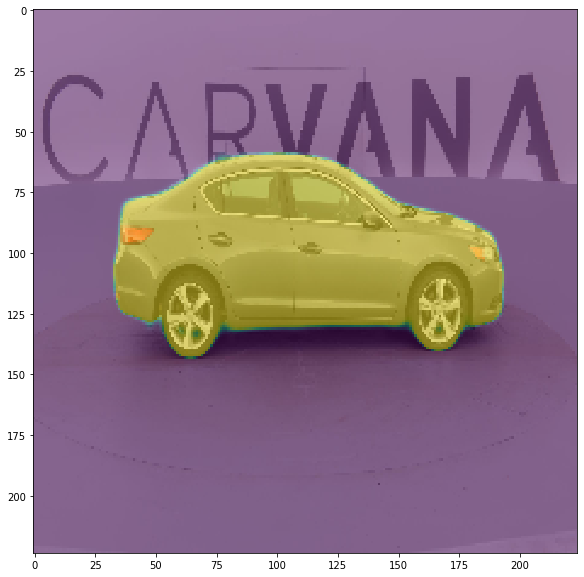

In [324]:
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.imshow(mask[:, :, 0], alpha=0.5)